# 1. Import libraries

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix , classification_report,ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score,roc_curve,auc
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy


# From here, add any libraries that you might need for the rest of your code
import zipfile


# 2. Load and pre-process the dataset

In [2]:
# IF YOU USE GOOGLE COLAB AND HAVE THE DATA STORED ON YOUR GOOGLE DRIVE:
from google.colab import drive
drive.mount('/content/drive') # mounts your Google Drive



Mounted at /content/drive


In [3]:
# SET THE PATHS BASED ON WHERE YOU STORED THE DATASET:

# IF YOU USE GOOGLE COLAB AND HAVE THE DATA STORED ON YOUR GOOGLE DRIVE:
!cp -r "/content/drive/MyDrive/Deep_Learning_Assignment_Group_12/Skin_Lesion_Dataset/Train" /content/  # copies the data from your Google Drive to colab's VM (may take a few mins; set path to your Google directory).
#!unzip -q "/content/drive/MyDrive/Copy of Skin_Lesion_Dataset.zip" -d /content/data # Change the path if you move or rename the zip file.
dataset_dir = "/content/drive/MyDrive/Deep_Learning_Assignment_Group_12/Skin_Lesion_Dataset/Train"
 # points to the local copy on colab's virtual machine (VM)

# IF YOU USE YOUR OWN COMPUTER:
# dataset_dir = "C:/.../Skin_Lesion_Dataset/" # if you run the code locally, set this path to the directory where you stored the dataset.

# LIST THE CLASSES THAT EXIST WITHIN THIS DATASET:
CLASS_LABELS  = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC'] # creates a list of the 8 classes in this dataset (the dataset contains images of 8 types of skin lesion)
# note: class names are abbreviations f？or:
# ["Actinic Keratoses", "Basal Cell Carcinoma", "Benign Keratosis-like Lesions", "Dermatofibroma", "Melanoma", "Nevus", "Squamous Cell Carcinoma", "Vascular Lesions"]


In [4]:
## IMPORTANT: please remember that you are not allowed to change the
## loading and preprocessing code to improve model performance for this assignment.

# LOAD AND PREPROCESS THE DATA:

# set size of images (in pixels) after resizing
IMG_HEIGHT = 42
IMG_WIDTH = 42

# set batch size
BATCH_SIZE = 128

# set relative sizes of the test and val set
TEST_SIZE = 0.2   # 20% of all 27.934 images will be used for testing the model
VAL_SIZE = 0.2    # of the remaining images, 20% will be used for validation and 80% for training

# function for adding noise to the images
def add_noise(img):
    std_coeff = 20 * np.random.random()
    noise = np.random.normal(0, std_coeff, img.shape)
    img += noise
    img = np.clip(img, 0., 255.)
    return img

# build dataframe with file paths and labels
all_files = []
all_labels = []

for class_name in sorted(os.listdir(dataset_dir)):
    class_path = os.path.join(dataset_dir, class_name)
    if os.path.isdir(class_path):
        for fname in os.listdir(class_path):
            fpath = os.path.join(class_path, fname)
            all_files.append(fpath)
            all_labels.append(class_name)

df = pd.DataFrame({"filename": all_files, "class": all_labels})

# split the data into train / val / test
trainval_df, test_df = train_test_split(df, test_size=TEST_SIZE, stratify=df["class"], random_state=31) # split all data into trainval + test
train_df, val_df   = train_test_split(trainval_df, test_size=VAL_SIZE, stratify=trainval_df["class"], random_state=31)  # split trainval data into train + val

# define generators
train_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=add_noise) # note: noise is only added to the train samples.
val_test_datagen = ImageDataGenerator(rescale=1./255)

# apply generators
train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

val_data = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=True,
    seed=7
)

test_data = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col="filename",
    y_col="class",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)

print("Data loading completed successfully.")
print(f"Number of training samples: {train_data.samples}")
print(f"Number of validation samples: {val_data.samples}")
print(f"Number of test samples: {test_data.samples}")
print(f"Class names: {train_data.class_indices}")

Found 18013 validated image filenames belonging to 8 classes.
Found 4504 validated image filenames belonging to 8 classes.
Found 5630 validated image filenames belonging to 8 classes.
Data loading completed successfully.
Number of training samples: 18013
Number of validation samples: 4504
Number of test samples: 5630
Class names: {'AK': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'SCC': 6, 'VASC': 7}


# 3. Visualise data and plot data distribution

In [5]:
print(train_df.columns)

Index(['filename', 'class'], dtype='object')


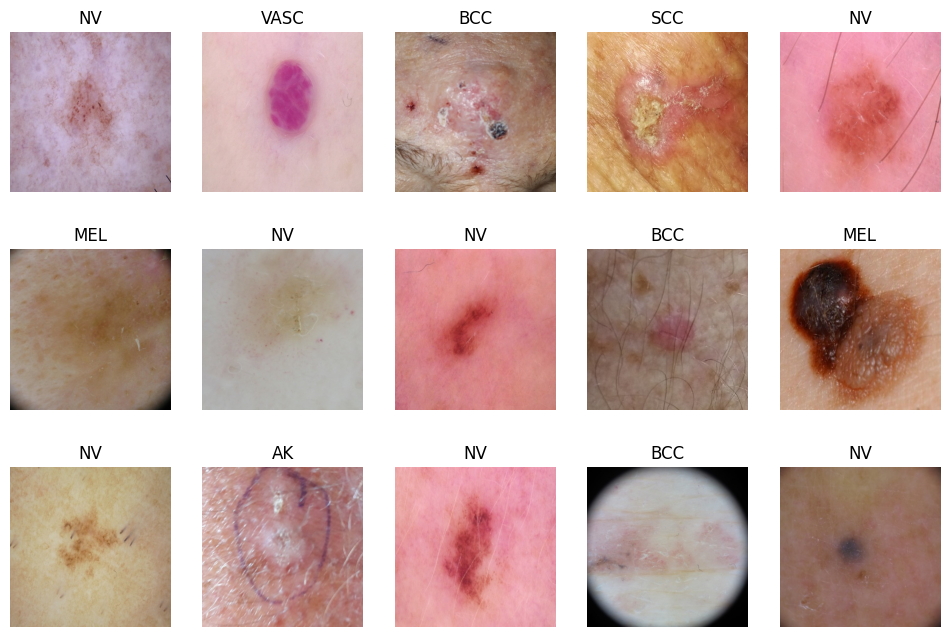

In [6]:
# Randomly select 15 samples from the dataset.
samples = train_df.sample(15, random_state=42)

# Display sample images along with the corresponding label.
plt.figure(figsize=(12,8))
for i, row in enumerate(samples.itertuples()):
  img = plt.imread(row.filename)
  plt.subplot(3,5,i+1)
  plt.imshow(img)
  plt.title(row._2)
  plt.axis("off")
plt.show()

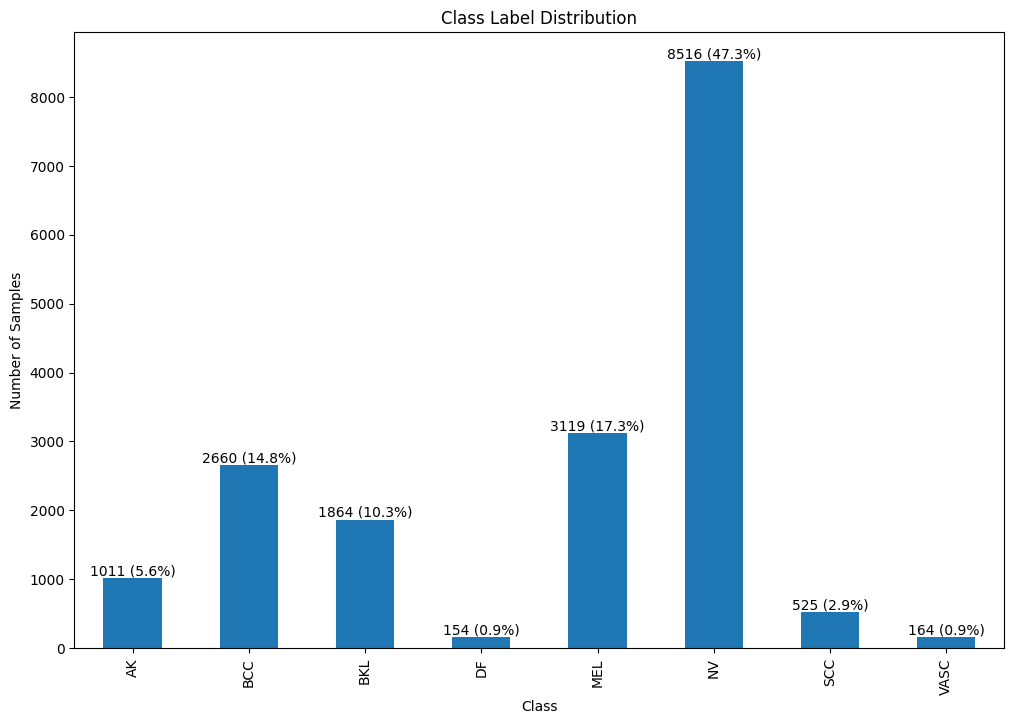

In [7]:
# Calculate the number of samples per class
class_counts = train_df["class"].value_counts().sort_index()
total = class_counts.sum()

# Plot bar chart with count + percentage
ax = class_counts.plot(kind="bar", figsize=(12,8))
plt.title("Class Label Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")

for i, count in enumerate(class_counts):
    pct = 100 * count / total
    ax.text(i, count, f"{count} ({pct:.1f}%)", ha='center', va='bottom')

# 4. Model Design and Train and Evaluation functions

In [8]:
#BASELINE model
INPUT_SHAPE = (42, 42, 3)
NUM_CLASSES = 8

def baseline_cnn(input_shape=INPUT_SHAPE, num_classes=NUM_CLASSES):
    model = Sequential([
        Conv2D(16, (3,3), padding='same', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(16, (3,3), padding='same', activation='relu'),

        MaxPooling2D(pool_size=(2,2)),

        Flatten(),
        Dense(128, activation='relu'),
        Dense(num_classes, activation='softmax')  #last layer activation chosen
    ])
    return model

model = baseline_cnn()
model.compile(optimizer=Adam(1e-3),
              loss=CategoricalCrossentropy(),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 42, 42, 16)     │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 21, 21, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 16)     │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 208,728 (815.34 KB)

 Trainable params: 208,728 (815.34 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
#Loss & accuracy per epoch- validation and training set (may take a while to load)
history = model.fit(train_data, validation_data=val_data, epochs=15)

Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 89s 602ms/step - accuracy: 0.4713 - loss: 1.4937 - val_accuracy: 0.5273 - val_loss: 1.3025
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 571ms/step - accuracy: 0.5364 - loss: 1.2729 - val_accuracy: 0.5568 - val_loss: 1.2318
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 568ms/step - accuracy: 0.5639 - loss: 1.2128 - val_accuracy: 0.5766 - val_loss: 1.1857
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 82s 581ms/step - accuracy: 0.5863 - loss: 1.1432 - val_accuracy: 0.5824 - val_loss: 1.1520
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 564ms/step - accuracy: 0.5928 - loss: 1.1235 - val_accuracy: 0.6010 - val_loss: 1.1270
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 568ms/step - accuracy: 0.6003 - loss: 1.0974 - val_accuracy: 0.6086 - val_loss: 1.0899
Epoch 7/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 80s 569ms/step - accuracy: 0.6148 - loss: 1.0540 - val_accuracy: 0.6143 - val_loss: 1.0739
Epoch 8/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 81s 572ms/step - accuracy: 0.6267 - loss: 1

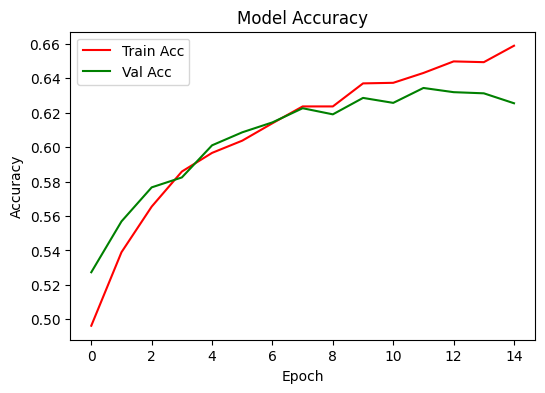

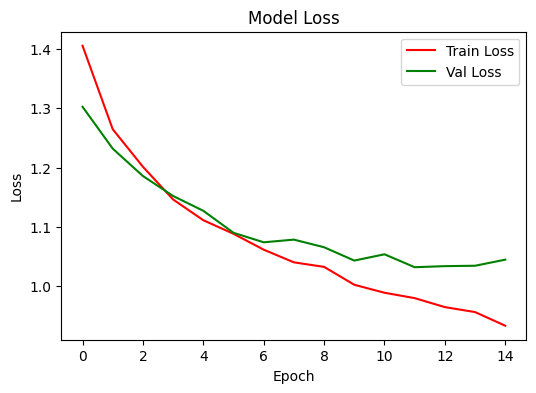

In [10]:

# Accuracy plot for the training and validation set
plt.figure(figsize=(6,4))
plt.plot(history.history['accuracy'], label='Train Acc', color='red')
plt.plot(history.history['val_accuracy'], label='Val Acc', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Loss plot for the training and validation set
plt.figure(figsize=(6,4))
plt.plot(history.history['loss'], label='Train Loss', color='red')
plt.plot(history.history['val_loss'], label='Val Loss', color='green')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

44/44 ━━━━━━━━━━━━━━━━━━━━ 20s 454ms/step


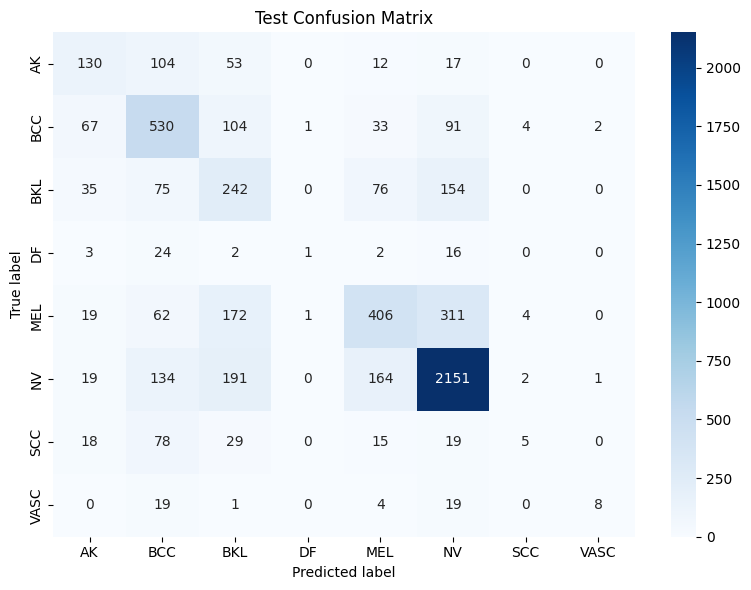

36/36 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step


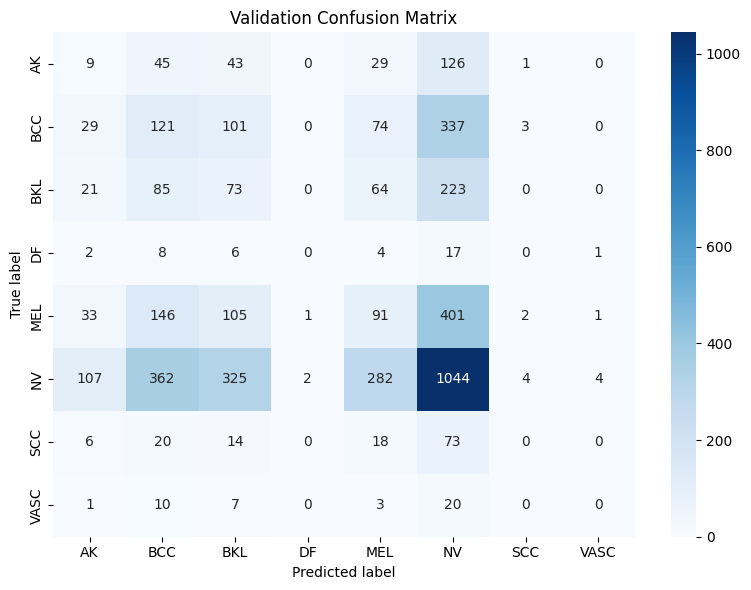

In [11]:
#Confusion matrix for the test set
y_true = test_data.classes
y_pred_probs = model.predict(test_data)
num_classes = len(test_data.class_indices)


if y_pred_probs.ndim != 2 or y_pred_probs.shape[1] != num_classes:
    raise ValueError(f"Unexpected prediction shape: {y_pred_probs.shape}")

y_pred = np.argmax(y_pred_probs, axis=1)
class_names = list(test_data.class_indices.keys())


cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Test Confusion Matrix')
plt.tight_layout()
plt.show()

#Confusion Matrix for the validation set
y_val_true = val_data.classes
y_val_pred_probs = model.predict(val_data)
num_classes = len(val_data.class_indices)

if y_val_pred_probs.ndim != 2 or y_val_pred_probs.shape[1] != num_classes:
    raise ValueError(f"Unexpected prediction shape: {y_val_pred_probs.shape}")

y_val_pred = np.argmax(y_val_pred_probs, axis=1)
class_names = list(val_data.class_indices.keys())

cm_val = confusion_matrix(y_val_true, y_val_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm_val,
            annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Validation Confusion Matrix')
plt.tight_layout()
plt.show()

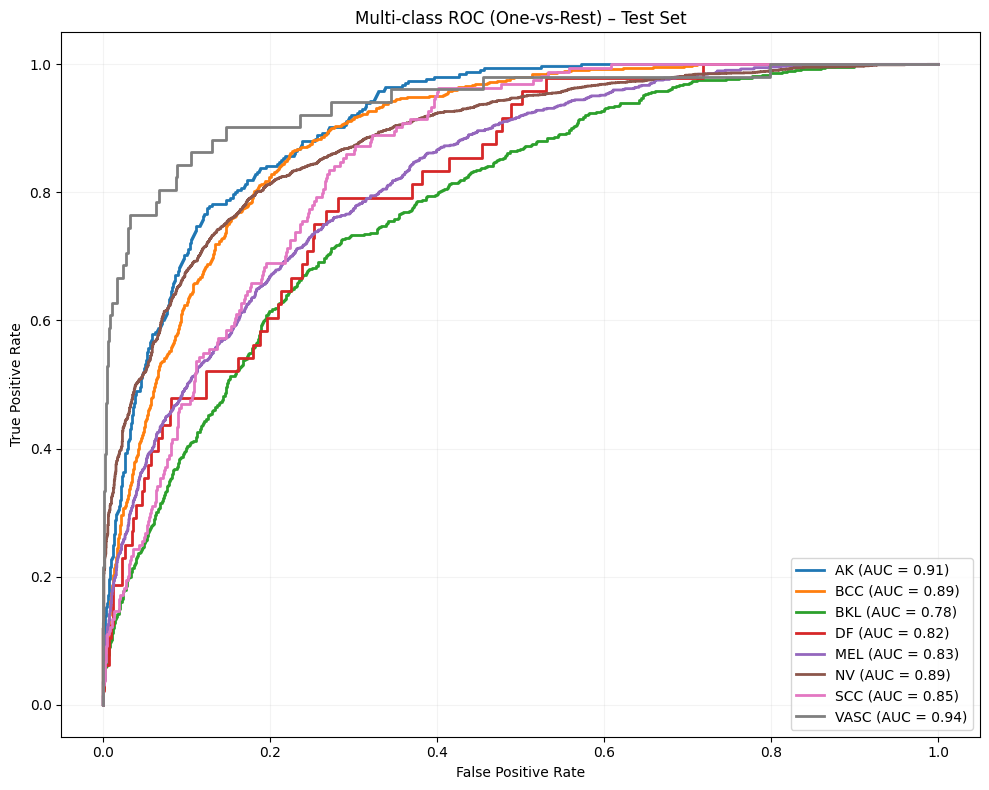

36/36 ━━━━━━━━━━━━━━━━━━━━ 15s 417ms/step


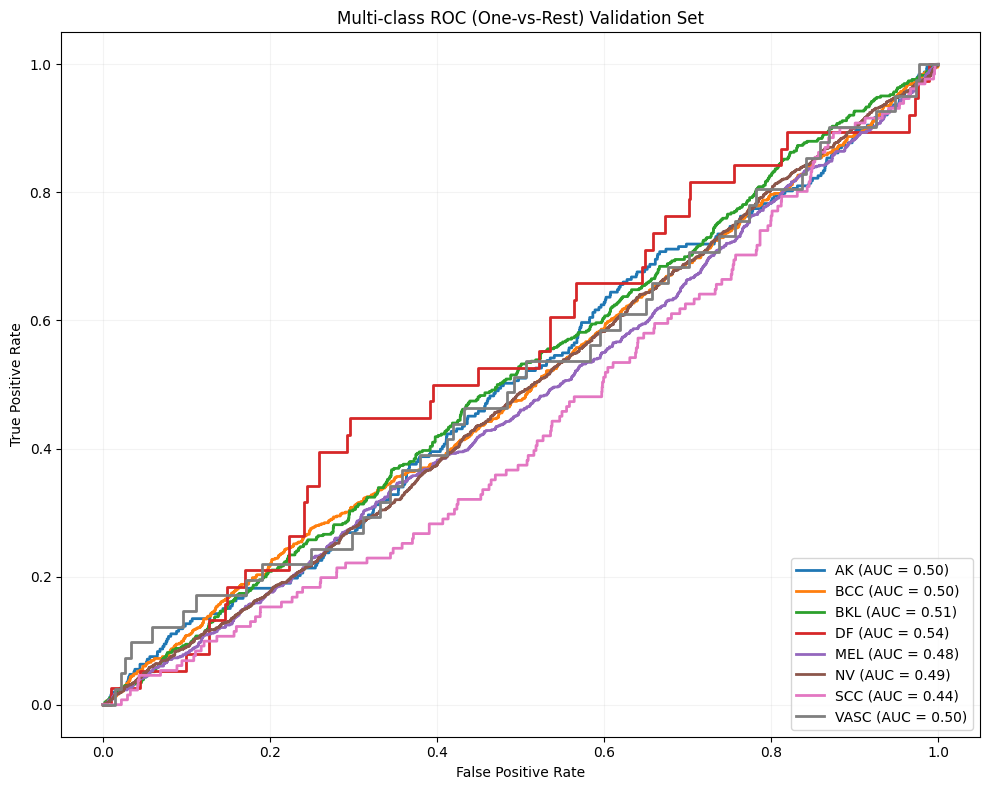

In [12]:
#ROC with AUC values for the test set

lb = LabelBinarizer()
lb.fit(y_true)
Y_true_bin = lb.transform(y_true)

if Y_true_bin.ndim == 1:
    Y_true_bin = np.column_stack([1 - Y_true_bin, Y_true_bin])


plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(Y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")


plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC (One-vs-Rest) – Test Set")
plt.legend(loc="lower right", frameon=True)
plt.grid(alpha=0.15)
plt.tight_layout()
plt.show()

#ROC with AUC values for the validation set
y_val_true = val_data.classes
y_val_pred_probs = model.predict(val_data)

Y_val_true_bin = lb.transform(y_val_true)


if Y_val_true_bin.ndim == 1:
    Y_val_true_bin = np.column_stack([1 - Y_val_true_bin, Y_val_true_bin])

plt.figure(figsize=(10, 8))
for i, name in enumerate(class_names):
    fpr, tpr, _ = roc_curve(Y_val_true_bin[:, i], y_val_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.2f})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Multi-class ROC (One-vs-Rest) Validation Set")
plt.legend(loc="lower right", frameon=True)
plt.grid(alpha=0.15)
plt.tight_layout()
plt.show()

# 4.2. Fine tuning

In [13]:

from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.losses import CategoricalCrossentropy


model = Sequential([
    # Data augmentation
    keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1)
    ], name="data_augmentation"),

    # Convolutional blocks, kernel size 3x3
    layers.Conv2D(32, (3,3), activation='relu', padding='same', input_shape=(42,42,3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, (3,3), activation='relu', padding='same'),
    layers.BatchNormalization(),

    # Regularization and Dense layers
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(8, activation='softmax')
])

# Optimizer and learning rate
optimizer = Adam(learning_rate=3e-4)

# Loss function and accuracy metric
loss = CategoricalCrossentropy(label_smoothing=0.1)
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])


# Plateau and early stop
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6, verbose=1)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)


#Train, epochs 50
history_v4b = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[reduce_lr, early_stop],
    verbose=2
)

# Save model if needed
#model.save('variation4b.keras')

Epoch 1/50
141/141 - 88s - 625ms/step - accuracy: 0.5193 - loss: 1.4833 - val_accuracy: 0.1476 - val_loss: 2.1894 - learning_rate: 3.0000e-04
Epoch 2/50
141/141 - 140s - 991ms/step - accuracy: 0.5778 - loss: 1.3691 - val_accuracy: 0.1461 - val_loss: 2.1459 - learning_rate: 3.0000e-04
Epoch 3/50
141/141 - 81s - 576ms/step - accuracy: 0.6036 - loss: 1.3164 - val_accuracy: 0.5069 - val_loss: 1.5889 - learning_rate: 3.0000e-04
Epoch 4/50
141/141 - 81s - 576ms/step - accuracy: 0.6149 - loss: 1.2932 - val_accuracy: 0.5750 - val_loss: 1.4261 - learning_rate: 3.0000e-04
Epoch 5/50
141/141 - 83s - 588ms/step - accuracy: 0.6226 - loss: 1.2707 - val_accuracy: 0.6212 - val_loss: 1.2861 - learning_rate: 3.0000e-04
Epoch 6/50
141/141 - 81s - 576ms/step - accuracy: 0.6313 - loss: 1.2548 - val_accuracy: 0.6270 - val_loss: 1.2626 - learning_rate: 3.0000e-04
Epoch 7/50
141/141 - 80s - 570ms/step - accuracy: 0.6367 - loss: 1.2420 - val_accuracy: 0.5948 - val_loss: 1.3382 - learning_rate: 3.0000e-04
Epoch

# 5. Model training _ Transfer Learning

In [14]:
# Import for transfer learning
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import label_binarize

# VGG16 parameters
img_height, img_width = 224, 224
num_classes = 8  # 8 skin lesion classes

# Redefine generators for VGG16 (RGB, preprocess_input; no changes to original loading)
data_gen_rgb = ImageDataGenerator(preprocessing_function=preprocess_input)
train_data_rgb = data_gen_rgb.flow_from_dataframe(
    train_df, x_col="filename", y_col="class", target_size=(img_height, img_width),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True, color_mode='rgb'
)
val_data_rgb = data_gen_rgb.flow_from_dataframe(
    val_df, x_col="filename", y_col="class", target_size=(img_height, img_width),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False, color_mode='rgb'
)
test_data_rgb = data_gen_rgb.flow_from_dataframe(
    test_df, x_col="filename", y_col="class", target_size=(img_height, img_width),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False, color_mode='rgb'
)

# Build VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers:  # Freeze until FC layer as per assignment
    layer.trainable = False

vgg_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),  # Custom FC layers (add as many as you like)
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

vgg_model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
vgg_history = vgg_model.fit(train_data_rgb, validation_data=val_data_rgb, epochs=15)

# Evaluate
test_loss, test_acc = vgg_model.evaluate(test_data_rgb)
print(f"VGG16 Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Found 18013 validated image filenames belonging to 8 classes.
Found 4504 validated image filenames belonging to 8 classes.
Found 5630 validated image filenames belonging to 8 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.3014 - loss: 3.6147 - val_accuracy: 0.5562 - val_loss: 1.4612
Epoch 2/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 122s 862ms/step - accuracy: 0.4678 - loss: 1.8686 - val_accuracy: 0.5788 - val_loss: 1.2687
Epoch 3/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 123s 867ms/step - accuracy: 0.5091 - loss: 1.5135 - val_accuracy: 0.5919 - val_loss: 1.1933
Epoch 4/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 124s 880ms/step - accuracy: 0.5385 - loss: 1.3555 - val_accuracy: 0.6006 - val_loss: 1.1547
Epoch 5/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 123s 871ms/step - accuracy: 0.5605 - loss: 1.2797 - val_accuracy: 0.6041 - val_loss: 1.1244
Epoch 6/15
141/141 ━━━━━━━━━━━━━━━━━━━━ 123s 871ms/step - accuracy: 0.5780 - loss: 1.2182 - val_accuracy: 0.

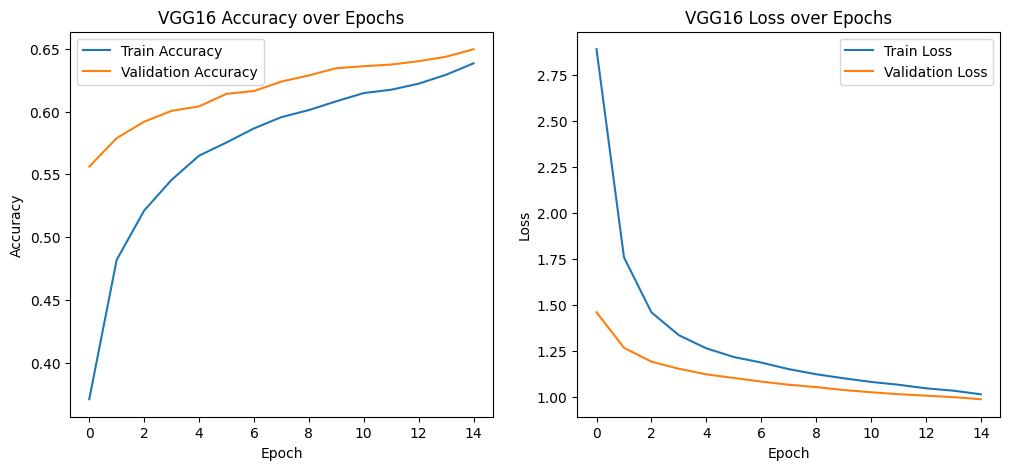

44/44 ━━━━━━━━━━━━━━━━━━━━ 34s 732ms/step


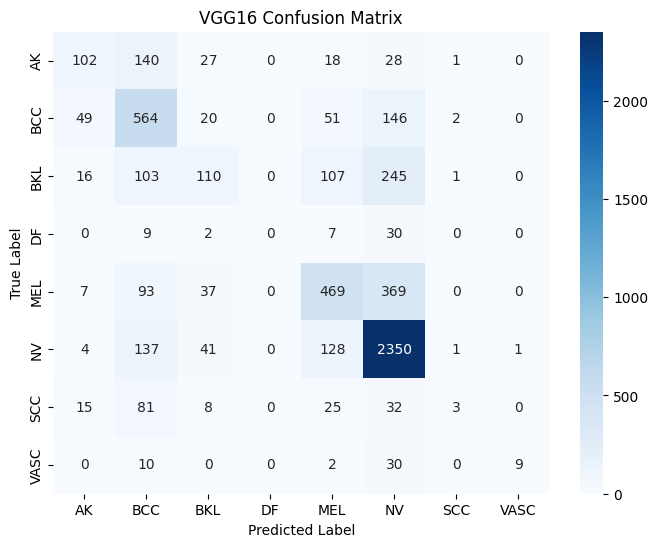

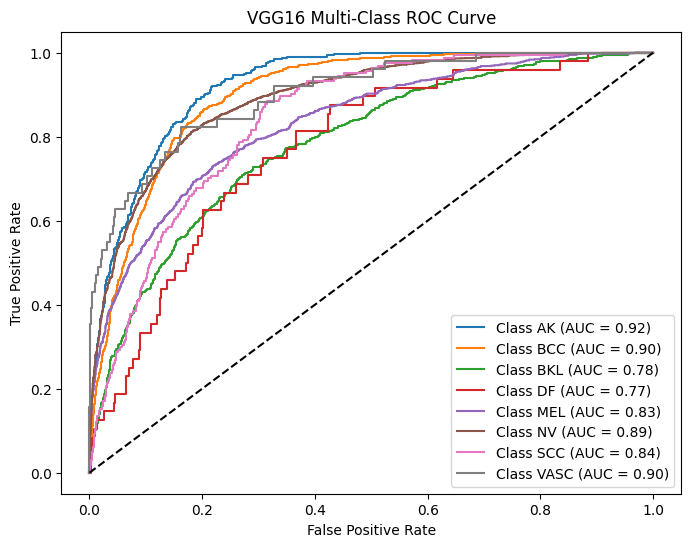

              precision    recall  f1-score   support

          AK       0.53      0.32      0.40       316
         BCC       0.50      0.68      0.57       832
         BKL       0.45      0.19      0.27       582
          DF       0.00      0.00      0.00        48
         MEL       0.58      0.48      0.53       975
          NV       0.73      0.88      0.80      2662
         SCC       0.38      0.02      0.03       164
        VASC       0.90      0.18      0.30        51

    accuracy                           0.64      5630
   macro avg       0.51      0.34      0.36      5630
weighted avg       0.61      0.64      0.61      5630



In [15]:
# Training curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(vgg_history.history['accuracy'], label='Train Accuracy')
plt.plot(vgg_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('VGG16 Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(vgg_history.history['loss'], label='Train Loss')
plt.plot(vgg_history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Predictions for VGG16
y_true_vgg = test_data_rgb.classes
y_pred_probs_vgg = vgg_model.predict(test_data_rgb)
y_pred_vgg = np.argmax(y_pred_probs_vgg, axis=1)

# Confusion Matrix for VGG16
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_vgg, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_LABELS, yticklabels=CLASS_LABELS)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('VGG16 Confusion Matrix')
plt.show()

# ROC Curve for VGG16
y_true_bin_vgg = label_binarize(y_true_vgg, classes=range(num_classes))
fpr_vgg, tpr_vgg, roc_auc_vgg = {}, {}, {}
for i in range(num_classes):
    fpr_vgg[i], tpr_vgg[i], _ = roc_curve(y_true_bin_vgg[:, i], y_pred_probs_vgg[:, i])
    roc_auc_vgg[i] = auc(fpr_vgg[i], tpr_vgg[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr_vgg[i], tpr_vgg[i], label=f'Class {CLASS_LABELS[i]} (AUC = {roc_auc_vgg[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('VGG16 Multi-Class ROC Curve')
plt.legend(loc='best')
plt.show()

print(classification_report(y_true_vgg, y_pred_vgg, target_names=CLASS_LABELS))

# 6. Model evaluation

In [16]:
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

print("Classification Report (Test Set):")
print(classification_report(y_true, y_pred, target_names=class_names))

overall_acc   = accuracy_score(y_true, y_pred)
macro_f1      = f1_score(y_true, y_pred, average='macro')
weighted_f1   = f1_score(y_true, y_pred, average='weighted')
macro_prec    = precision_score(y_true, y_pred, average='macro')
macro_recall  = recall_score(y_true, y_pred, average='macro')

print(f"Overall Accuracy: {overall_acc:.3f}")
print(f"Macro F1: {macro_f1:.3f} | Weighted F1: {weighted_f1:.3f}")
print(f"Macro Precision: {macro_prec:.3f} | Macro Recall: {macro_recall:.3f}")

Classification Report (Test Set):
              precision    recall  f1-score   support

          AK       0.45      0.41      0.43       316
         BCC       0.52      0.64      0.57       832
         BKL       0.30      0.42      0.35       582
          DF       0.33      0.02      0.04        48
         MEL       0.57      0.42      0.48       975
          NV       0.77      0.81      0.79      2662
         SCC       0.33      0.03      0.06       164
        VASC       0.73      0.16      0.26        51

    accuracy                           0.62      5630
   macro avg       0.50      0.36      0.37      5630
weighted avg       0.62      0.62      0.61      5630

Overall Accuracy: 0.617
Macro F1: 0.372 | Weighted F1: 0.606
Macro Precision: 0.501 | Macro Recall: 0.362
